In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Isochrones

Recall that stellar clusters are gravitationally bound groupings of stars born at the same time.  By looking at the H-R diagram of a cluster -- specifically where the population _leaves_ the main sequence -- we can determine the age of the cluster.  To do this we must know the typical main sequence lifetime of stars, which depends on their mass, metalicity, etc. and for that we must turn to stellar modeling.  [MESA](https://docs.mesastar.org) is a stellar modeling library which incorporates the physics important for stellar evolution into 1-D models of stars.  The results useful for our purposes are stellar evolution tracks, the expected trajectory of the star through the H-R diagram as it evolves in time.

[MIST](http://waps.cfa.harvard.edu/MIST/index.html) is an effort to supply a large database of MESA stellar track simulations for the purpose of producing isochrones.  If you imagine stacking up a cluster's worth of stellar evolution tracks, slicing through them at fixed age will produce an isochrone.

I've used the [MIST isochrone interpolator](http://waps.cfa.harvard.edu/MIST/interp_isos.html) to produce several isochrones based on known properties of M4 (metalicity, reddening due to dust, etc.), which I've included in the `data/` directory.

There is a lot of info in these files.  To save ourselves a _big_ headache in parsing them, we'll make use of a python script authored by [Jieun Choi](https://github.com/jieunchoi).

In [2]:
!wget -nc https://github.com/jieunchoi/MIST_codes/raw/master/scripts/read_mist_models.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


Now let's read in the file.

In [ ]:
import read_mist_models

filename = '../data/m4_isochrones.iso.cmd'
iso = read_mist_models.ISOCMD(filename)

The information we're after is in `iso.isocmds` (CMD: color-magnitude diagram).

In [4]:
type(iso.isocmds), len(iso.isocmds)

(list, 7)

We see this is a list with 7 elements.  These 7 CMDs are isochrones for 7 different ages, which we can see in the table of each.  Let's inspect the first one.

In [5]:
iso_array = iso.isocmds[0]
type(iso_array)

numpy.ndarray

This are numpy record arrays (basically numpy arrays with names columns).

In [6]:
iso_array.dtype.names

('EEP',
 'log10_isochrone_age_yr',
 'initial_mass',
 'star_mass',
 'log_Teff',
 'log_g',
 'log_L',
 '[Fe/H]_init',
 '[Fe/H]',
 'Bessell_U',
 'Bessell_B',
 'Bessell_V',
 'Bessell_R',
 'Bessell_I',
 '2MASS_J',
 '2MASS_H',
 '2MASS_Ks',
 'Kepler_Kp',
 'Kepler_D51',
 'Hipparcos_Hp',
 'Tycho_B',
 'Tycho_V',
 'Gaia_G_DR2Rev',
 'Gaia_BP_DR2Rev',
 'Gaia_RP_DR2Rev',
 'Gaia_G_MAW',
 'Gaia_BP_MAWb',
 'Gaia_BP_MAWf',
 'Gaia_RP_MAW',
 'TESS',
 'Gaia_G_EDR3',
 'Gaia_BP_EDR3',
 'Gaia_RP_EDR3',
 'phase')

For a more detailed description see [here](http://waps.cfa.harvard.edu/MIST/README_tables.pdf).  Most of these columns are synthetic photometry (magnitude measurements) for various telescopes and filters (we'll be using the `Gaia_X_EDR3` ones).  `log10_isochrone_age_yr` is what it sounds like, and is different for each of the 7 CMDs in the list.

In [7]:
# Compute our color quantity (BP - RP) for the isochrone and plot G vs BP-RP for the isochrone. 
#Don't forget to invert the y-axis!

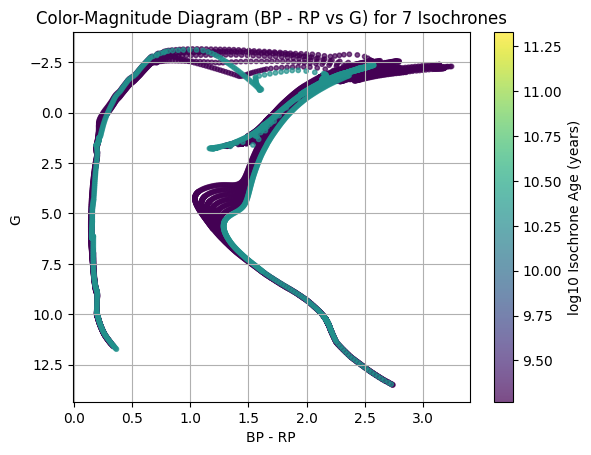

In [ ]:
for i in range(7):  
    gaia_bp = iso.isocmds[i]['Gaia_BP_EDR3']
    gaia_rp = iso.isocmds[i]['Gaia_RP_EDR3']
    gaia_g = iso.isocmds[i]['Gaia_G_EDR3']
    age = iso.isocmds[i]['log10_isochrone_age_yr']
    
    color_index = gaia_bp - gaia_rp
    
    plt.scatter(color_index, gaia_g, c=age, cmap='viridis', s=10, alpha=0.7)

plt.gca().invert_yaxis()
plt.colorbar(label='log10 Isochrone Age (years)')
plt.grid(True)
plt.show()

This includes _all_ phases of stellar evolution.  If our focus is to date the cluster, we really only care about the main sequence and evolutionary phases immediately after (red giant) to find the turnoff.  `phase` indicates this the stellar evolution phase along the isochrone.  We can select the phases we're after:

In [9]:
phase_sel = (iso_array['phase'] >= 0) & (iso_array['phase'] < 3)

In [10]:
# Use the selection array to downselect the isochrone and plot it

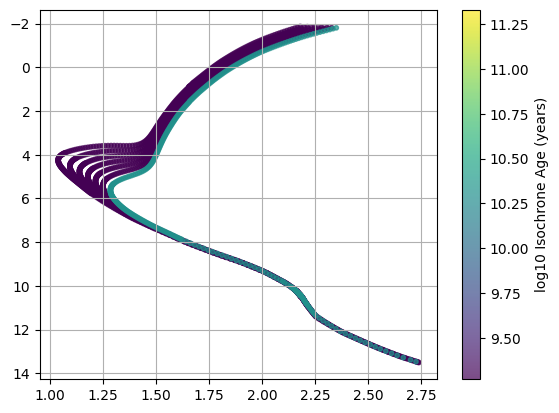

In [11]:
for i in range(7):  
    gaia_bp = iso.isocmds[i]['Gaia_BP_EDR3']
    gaia_rp = iso.isocmds[i]['Gaia_RP_EDR3']
    gaia_g = iso.isocmds[i]['Gaia_G_EDR3']
    age = iso.isocmds[i]['log10_isochrone_age_yr']
    phase = iso.isocmds[i]['phase']  

    phase_sel = (phase >= 0) & (phase < 3)  #applying selection to all 7 cmds
    
    selected_color_index = (gaia_bp - gaia_rp)[phase_sel]
    selected_gaia_g = gaia_g[phase_sel]
    selected_age = age[phase_sel]

    plt.scatter(selected_color_index, selected_gaia_g, c=selected_age, cmap='viridis', s=10, alpha=0.7)

plt.gca().invert_yaxis()
plt.colorbar(label='log10 Isochrone Age (years)')
plt.grid(True)
plt.show()


One final tweak we must make is to account for the distance to the cluster.  Our y-axis isn't actually luminosity, it's the _apparent_ magnitude in the G-band.  What we've been calling `mg` in our previous use of Gaia data was actually derived from the G-band observations and corrected for the distance to each sourse based on parallax measurement (which gave us something like an intrinsic, rather than apparent, brightness).  We're going to know use the true G-band measurement, which is `phot_g_mean_mag`.

The isochrone simulation doesn't account for the faintness we would expect, so we'll need to do it ourselves by applying a [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus).

The cluster is 2.2 kpc away.  We'll use some convenience functions from astropy to compute the corresponding distance modulus.

In [12]:
!pip install --quiet astropy

In [13]:
import astropy.coordinates as coord
import astropy.units as u

distance = 2.2 * u.kpc
distmod = coord.Distance(distance).distmod.value
distmod

11.71211340411103

In [14]:
# Add this distance modulus to the G-band magnitude of the isochrone

In [15]:
gaia_g = iso_array['Gaia_G_EDR3']
adjusted_gaia_g = gaia_g + distmod
adjusted_gaia_g

array([25.1886684, 25.0985524, 25.0071864, ..., 23.2322574, 23.2675064,
       23.3023044])

# Overplot Gaia Observation

Finally, let's overplot the Gaia observations of confidently identified members of the M4 cluster.  Read in the cluster catalog we've worked with previously (`NGC6121-1.dat`), Gaia objects in the M4-neigborhood (`m4_gaia_source.csv`), and cross-match the catalogs to find the Gaia observations corresponding to the identified cluster members.

In [16]:
# Read M4 (NGC6121) and Gaia catalogd and crossmatch them

In [17]:
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
m4_df

,source_id,ra,dec,phot_g_mean_mag
0,6045504229661220736,245.99162,-26.34434,18.438
1,6045504981264184192,246.03035,-26.28057,18.769
2,6045508902585952640,245.88761,-26.24297,19.072
3,6045507180287440000,245.85343,-26.28453,18.495
4,6045503473747038464,245.87124,-26.34628,17.163
...,...,...,...,...
19503,6045337962873610240,245.13976,-27.09970,19.705
19504,6045298891556291712,245.48339,-27.19208,19.493
19505,6045305866578950784,245.69445,-27.06942,18.290
19506,6045303774938119808,245.80824,-27.07275,19.267


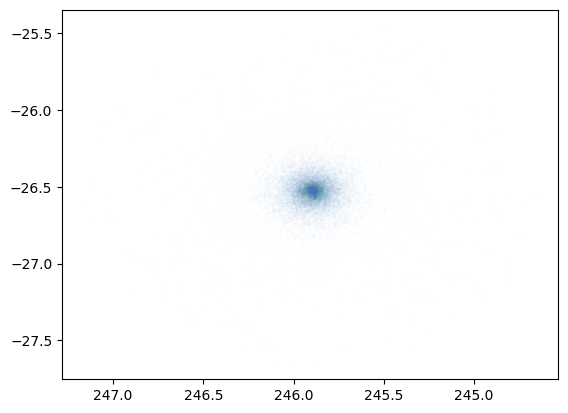

In [18]:
plt.scatter(m4_df.ra, m4_df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [19]:
df = pd.read_csv('../data/m4_gaia_source.csv')

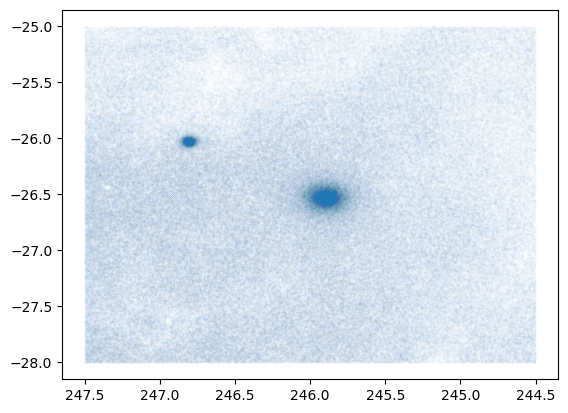

In [20]:
plt.scatter(df.ra, df.dec, s=0.0001)
plt.gca().invert_xaxis()

In [21]:
df.columns

Index(['designation', 'source_id', 'ra', 'dec', 'parallax', 'parallax_error',
       'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'astrometric_n_good_obs_al', 'astrometric_chi2_al',
       'visibility_periods_used', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

Now plot the M4 cluster members with the isochrone!

In [22]:
m4_df.columns

Index(['source_id', 'ra', 'dec', 'phot_g_mean_mag'], dtype='object')

In [ ]:
#cross-matching between the two data sets. 
# construct a selection array that selects for the cluster members identified in the cluster mini-catalog.

Cluster_sel = df['source_id'].isin(m4_df.source_id)
print(np.count_nonzero(Cluster_sel))

In [29]:
# plot M4 members and isochrone

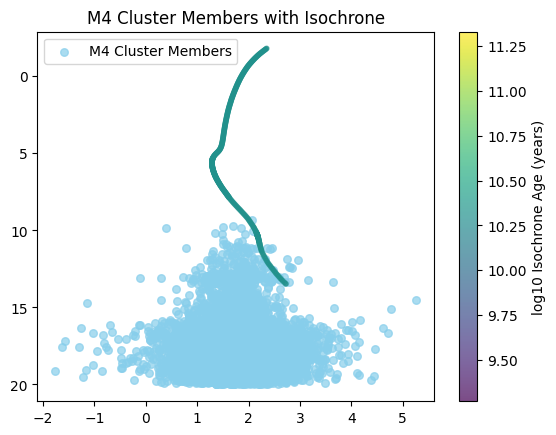

In [30]:
# Plot the M4 cluster members
plt.scatter(Cluster_sel['bp_rp'], Cluster_sel['phot_g_mean_mag_cluster'], 
            c='skyblue', label='M4 Cluster Members', s=30, alpha=0.7)

# Plot the isochrone 
plt.scatter(selected_color_index, selected_gaia_g, c=selected_age, cmap='viridis', s=10, alpha=0.7)
 
plt.colorbar(label='log10 Isochrone Age (years)')

plt.gca().invert_yaxis()
plt.title('M4 Cluster Members with Isochrone')
plt.legend()
plt.show()


How do they compare?  Explore the other isochrones.  Based on the fits (comparing by eye is sufficient), how old do you think 
Ans: They look close to me. I barely found it near to each other and it doesnot seems like color is changing according to bar therefore its hard to predict. 